# randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples
Andrew E. Davidson  
aedaivds@ucsc.edu
1/31/24

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

ref : [testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb](testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb)

**Logistic Regression baseline results** 
- pipelineStageName = "best10CuratedDegree1_ce467ff"
- 43 healthy donor plasma sample, 35 lung cancer plasma samples
- trained using all 78 samples
- specificity = 0.86
- sensitivity = 0.6

## best Random Forest Hyperparemeter tunning results:
- best was defined as set of parameters that yield the highest ROC AUC.  
- kfold with 5 splits. means are the average of all 5 split results
- "All" (Lung, LUAD, LUSC) did slightly better how ever it uses 3 times as many biomarkers (ie 30)

```
auc_mean
 0.751

accuracy_mean, accuracy_std,  
0.757,         0.059,        

sensitivity_mean, sensitivity_std, 
0.714,             0.156,           

specificity_mean, specificity_std
0.788,            0.051,
```

**Lung Biomarkers**  

FPR3 CSF3 SLAMF8 ENTPD2 MAGEE1 PCAT19 GRIP2 PTGIR RND1 CHRNB1  

see more complete overview /Users/andrewdavidson/googleUCSC/kimLab/grants/ARPA-WH/preliminaryData.docx34096


In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

# import joblib
import math
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
import pprint as pp
import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

import logging
#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

meaningOfLife = 42

/data/tmp/ipykernel_2964961/2426568945.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


outDir:
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavid

In [3]:
# import local 
from analysis.utilities import findFile
from intraExtraRNA.elifeUtilities import loadElifeTrainingData
from models.plotROC import plotROC
from pipeline.dataFactory.utilities import urlify

# Lung features

In [4]:
%%time
# load training data
pipelineStageName = "best10CuratedDegree1_ce467ff"
features = ["Lung"]
selectElifeCategories = ["Healthy donor", "Lung Cancer"]
HUGO_EMGenes, elifeLungGenes, countDF, metaDF, XNP, yNP = loadElifeTrainingData(pipelineStageName,
                                                                                     features,
                                                                                     selectElifeCategories,
                                                                                     )

print(f'XNP.shape : {XNP.shape} yNP.shape : {yNP.shape} number of Healthy Control : {np.sum(yNP)}')
print(f'HUGO_EMGenes\n{HUGO_EMGenes}')
metaDF.groupby("diagnosis").count()

2024-04-08 11:17:49,870 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:177] [len(elifeLungGenes) : 10]
2024-04-08 11:17:49,872 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:178] [missingElifeGenes
 : []]


refSeq2ENSGDF.loc[selectRows, :] :
          HUGO               ENSG bioType
203145  PCAT19  ENSG00000267107.8  lncRNA
XNP.shape : (78, 10) yNP.shape : (78,) number of Healthy Control : 35
HUGO_EMGenes
['FPR3', 'CSF3', 'SLAMF8', 'ENTPD2', 'MAGEE1', 'PCAT19', 'GRIP2', 'PTGIR', 'RND1', 'CHRNB1']
CPU times: user 23.3 s, sys: 2.74 s, total: 26.1 s
Wall time: 26.1 s


,sample_id
diagnosis,
Colorectal Cancer,53
Esophagus Cancer,31
Healthy donor,43
Liver Cancer,26
Lung Cancer,35
Stomach Cancer,36


In [5]:
# find best random forest parameters
searchResultsDir = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning"
modelOut = f'{searchResultsDir}/randomForestHyperparmeterLung.sh.out'
outFile = "randomForestHyperparmeterSearch.csv"
fpath = modelOut + "/" + outFile

print(f'fpath:\n {fpath}')
rfhpDF = pd.read_csv(fpath)

fpath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterLung.sh.out/randomForestHyperparmeterSearch.csv


In [6]:
# count the number of nana
if rfhpDF.isna().sum().sum() :
    logger.error("!!!!! warning max_depth, max_features, and n_estimators must be integers!!!!!!")
    print('\neasy fix is write a function that just corrects the few hyper parameter sets you want to use')
    print("if sum > 0 check dtype")
    print(f'\n{rfhpDF.isna().sum()}\n')
    rfhpDF.info()


2024-04-08 11:17:49,941 ERROR randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples <module>() line:3] [!!!!! warning max_depth, max_features, and n_estimators must be integers!!!!!!]



easy fix is write a function that just corrects the few hyper parameter sets you want to use
if sum > 0 check dtype

accuracy_mean         0
accuracy_std          0
sensitivity_mean      0
sensitivity_std       0
specificity_mean      0
specificity_std       0
auc_mean              0
auc_std               0
max_features          0
max_samples         336
n_estimators          0
max_depth           462
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3696 entries, 0 to 3695
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   accuracy_mean     3696 non-null   float64
 1   accuracy_std      3696 non-null   float64
 2   sensitivity_mean  3696 non-null   float64
 3   sensitivity_std   3696 non-null   float64
 4   specificity_mean  3696 non-null   float64
 5   specificity_std   3696 non-null   float64
 6   auc_mean          3696 non-null   float64
 7   auc_std           3696 non-null   float64
 8 

In [7]:
# clean up
# several parameters can be integers, floats, ... passing a float 1 != int 1, 
# see scikit learn doc and  randomForestHyperparmeterSearch.py
# rfhpDF["max_depth"] = rfhpDF.loc[:, "max_depth"].astype('int')
# rfhpDF["max_features"] = rfhpDF.loc[:, "max_features"].astype('int')
# rfhpDF["max_samples"] = rfhpDF.loc[:, "max_samples"].astype('float')
# rfhpDF["n_estimators"] = rfhpDF.loc[:, "n_estimators"].astype('int')

# print(f'rfhpDF.shape : {rfhpDF.shape}')
rfhpDF.head()

,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.757500,0.059184,0.714286,0.156492,0.788889,0.051520,0.751587,0.066371,3,1.0,500,NaN
1,0.755833,0.097632,0.714286,0.156492,0.783333,0.204238,0.748810,0.094926,1,NaN,50,6.0
2,0.745000,0.065691,0.714286,0.156492,0.766667,0.071578,0.740476,0.070869,4,0.9,2000,NaN
3,0.744167,0.080130,0.685714,0.106904,0.788889,0.137043,0.737302,0.076976,2,NaN,50,7.0
4,0.744167,0.080130,0.685714,0.106904,0.788889,0.137043,0.737302,0.076976,3,NaN,100,NaN


In [8]:
# get model parameters for search results with the highest AUC
bestParmetersDF = rfhpDF.sort_values(by='auc_mean', ascending=False).head(n=1)
# bestParmetersDF = bestParmetersDF.set_index("auc_mean")
display( bestParmetersDF )
parameterCols = ["max_features", "max_samples", "n_estimators", "max_depth"]
# bestParametersDict = bestParmetersDF.loc[:, parameterCols].to_dict()
# print(bestParametersDict)

# kwags= rfhpDF.loc[:, parameters].head(n=1).to_dict(orient="records")[0]

kwags = bestParmetersDF.loc[:, parameterCols].head(n=1).to_dict(orient="records")[0]

#
# pandas to csv will change int columns to float if one of the values is missing
# pandas uses Nan which is considered a float so the values in teh column get prompted
# to float
#
max_depth_value = kwags['max_depth']
if math.isnan(max_depth_value) :
    # print(type(kwags['max_depth']))
    # del kwags['max_depth'] #= 1.0 #  None # default value
    kwags['max_depth'] = None
else:
    kwags['max_depth'] = int(max_depth_value)
    

print(kwags)

,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.7575,0.059184,0.714286,0.156492,0.788889,0.05152,0.751587,0.066371,3,1.0,500,NaN


{'max_features': 3, 'max_samples': 1.0, 'n_estimators': 500, 'max_depth': None}


In [9]:
# create model
LungModel = RandomForestClassifier(**kwags)
LungModel

RandomForestClassifier(max_features=3, max_samples=1.0, n_estimators=500)

In [10]:
# train on all samples
LungModel.fit(XNP, yNP)
predictions  = LungModel.predict(XNP)
yProbability = LungModel.predict_proba(XNP)

yNP.shape : (78,)
yProbability.shape : (78, 2)


2024-04-08 11:17:51,510 WARNING randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples <module>() line:56] [plot may over estimate performance. Model was trained on all 75 cancer and healthy samples]


saved image to /private/groups/kimlab/aedavids/elife/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.out/img/elife-Lung-Cancer-Health-control-random-forest-GTEx-Lung-biomarkers.png


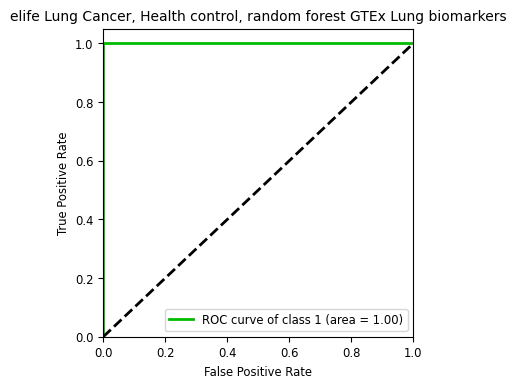

In [11]:
def plotROCWrapper(XNP :np.array, 
                yNP :np.array, 
                model,
                title:str ) -> tuple[plt.figure, plt.axes, dict[int, float]]:
    '''
    arguments:
        XNP :
            samples to create prediction for
        y : 
            ground truth labels
    
        model:
            trained model 

    returns 
        fig:

        panel :
        
        dictionary :
            key = yProbability column idx
            value = area under ROC curve
 
    '''
    predictions  = model.predict(XNP)
    yProbability = model.predict_proba(XNP)

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), ) #sharey=True
    
    #yProbability = yProbability[:,1]
    print(f'yNP.shape : {yNP.shape}')
    print(f'yProbability.shape : {yProbability.shape}' )
    
    classesToPlot = [1]
    aucDict = plotROC(
            axs, 
            yNP,
            yProbability,
            title,
            classesToPlot
    ) 

    return (fig, axs, aucDict)


title = "elife Lung Cancer, Health control, random forest GTEx Lung biomarkers"
fig, axs, aucDict = plotROCWrapper(XNP, 
            yNP, 
            LungModel, 
            title)

imgFilePath = f'{imgOut}/{urlify(title)}.png'
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

logger.warning(f'plot may over estimate performance. Model was trained on all 75 cancer and healthy samples')